In [2]:
import pandas as pd
import numpy as np

import sklearn
from sklearn.metrics import * 
# from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV
# from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

import seaborn as sns
import matplotlib.pyplot as plt

import time
# import xgboost as xgb

import torch.nn as nn
import torchvision
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchvision import datasets, models, transforms

import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torchvision.models.feature_extraction import create_feature_extractor, get_graph_node_names
import torchvision.models as models
from torchsummary import summary
from torch.utils.data import RandomSampler
from torchvision.utils import make_grid
%matplotlib inline


In [3]:
pd.options.display.max_seq_items = 20

In [3]:
#Downloading the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model= models.vgg16(pretrained=False)
# torch.save(model.state_dict(), 'vgg16_pretrained.ckpt')

#Modifying the last classifier layer to output 450 classes instead of 1000
model.classifier[6] = nn.Linear(4096, 450 , bias = True)

/opt/conda/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
## Functions for freezing and unfreezing relavant parts of the architecture.
def freeze_backbone(model):
    for param in model.features.parameters():
        param.requires_grad = False

def freeze_head(model):
    for param in model.classifier.parameters():
        param.requires_grad = False

def unfreeze_backbone(model):
    for param in model.features.parameters():
        param.requires_grad = True

def unfreeze_head(model):
    for param in model.classifier.parameters():
        param.requires_grad = True

In [ ]:
#Freezing the entire NN
unfreeze_backbone(model)
unfreeze_head(model)

In [4]:
import os
train_dir = "train"
test_dir = "test"
val_dir = "valid"
class_dict = {}
classes_1 = os.listdir(train_dir)
#Creating a dictionary of the classes and their corresponding img count
for class_name in classes_1:
    try:
        temp_path = os.path.join(train_dir, class_name)
        class_dict[class_name] = len(os.listdir(temp_path))
    except:
        pass
#Creating a dataframe of the classes and their corresponding img count
classes = pd.DataFrame(class_dict.items(), columns = ['class_name', 'count'])
#Sorting the dataframe by the count of the images
classes = classes.sort_values(by = 'count', ascending = False)
classes.reset_index(drop = True, inplace = True)  
#basic statistics of the classes  
stats = classes.describe()
display(stats)
#Defining outliers as classes that surpass the 75th percentile +- 1.5*IQR
high_ourliers = classes["class_name"][classes["count"] > stats["count"]["75%"] + 1.5 * (stats["count"]["75%"] - stats["count"]["25%"])].values
low_ourliers = classes["class_name"][classes["count"] < stats["count"]["25%"] - 1.5 * (stats["count"]["75%"] - stats["count"]["25%"])].values
#Print the results
print("High outliers: ", high_ourliers)
print("Low outliers: ", low_ourliers)

,count
count,450.000000
mean,156.946667
std,17.408029
min,130.000000
25%,144.000000
50%,155.000000
75%,163.000000
max,248.000000


High outliers:  ['HOUSE FINCH' 'D-ARNAUDS BARBET' 'OVENBIRD' 'SWINHOES PHEASANT'
 'WOOD DUCK' 'CASPIAN TERN' 'OYSTER CATCHER' 'DARK EYED JUNCO'
 'RED TAILED HAWK' 'VIOLET GREEN SWALLOW' 'SORA' 'CRIMSON SUNBIRD'
 'MARABOU STORK' 'CAMPO FLICKER' 'RED BEARDED BEE EATER' 'NORTHERN PARULA'
 'BANDED BROADBILL' 'RAZORBILL' 'VARIED THRUSH' 'SPOONBILL']
Low outliers:  []


In [5]:
model.to(device)
summary(model,(3,224,224))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [6]:
# load and transform data using ImageFolder

# VGG-16 Takes 224x224 images as input, so we resize all of them
data_transform = transforms.Compose([transforms.CenterCrop(224), 
                                      transforms.ToTensor()])

train_data = datasets.ImageFolder(train_dir, transform=data_transform)
valid_data = datasets.ImageFolder(val_dir, transform=data_transform)
test_data = datasets.ImageFolder(test_dir, transform=data_transform)
print(len(train_data),len(valid_data),len(test_data))
#Setting the corrosponding labels with their classes
idx_to_class = {v: k for k, v in train_data.class_to_idx.items()}


70626 2250 2250


In [7]:
# define dataloader parameters
batch_size = 20
num_workers= 0

# instantiate data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True )

valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)

test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
                                          num_workers=num_workers, shuffle=True)

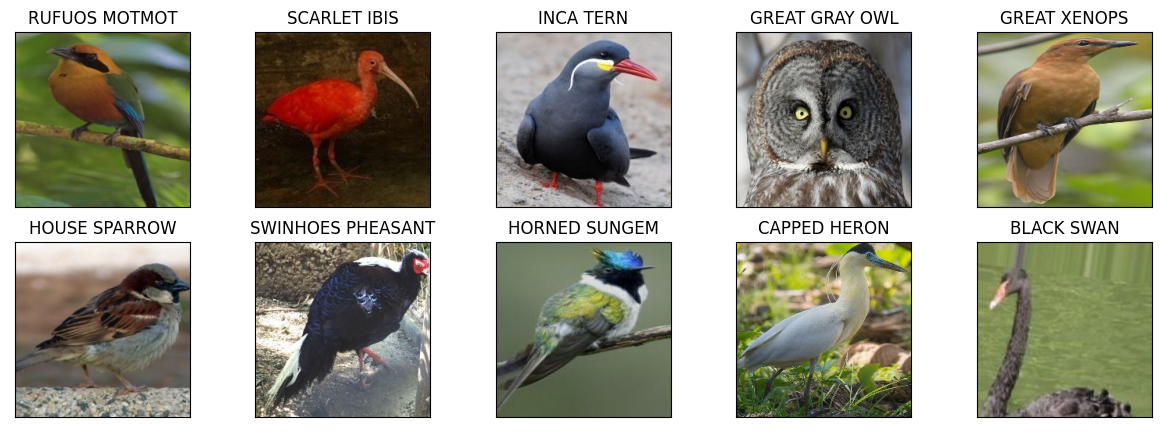

In [8]:
# Visualize some sample data

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(15,5))
for idx in np.arange(10):
    ax = fig.add_subplot(2, 5, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(idx_to_class[labels[idx].item()])

In [ ]:
import torch.optim as optim

# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer (stochastic gradient descent) and learning rate = 0.001
optimizer = optim.SGD(model.classifier.parameters(), lr=0.001)

In [ ]:
# number of epochs to train the model
n_epochs = 15
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
valid_loss_min = np.Inf # track change in validation loss
model.to(device)

for epoch in range(1, n_epochs+1):
    print("epoch number : ",epoch)

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    #Model training 
    count = 0 
    model.train()
    for data, target in train_loader:
        count += len(target)
        if count % 2000 == 0:
            print(count,"/","70000")
        # move tensors to GPU if CUDA is available
        data, target = data.to(device), target.to(device)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        count += len(target)
        if count % 2000 == 0:
            print(count,"/",len(train_data))
            print(f"train loss at epoch {epoch} and iteration {count/20} : ",train_loss)
    print("train loss : ",train_loss)

    #Model validation
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        data, target = data.to(device) ,target.to(device)
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        valid_loss_min = valid_loss
        
        model_scripted = torch.jit.script(model) # Export to TorchScript
        model_scripted.save('model_scripted.pt') # Save
        
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, "Untitled Folder/model.pt")

In [ ]:
# track test loss 
# over 5 flower classes
test_loss = 0.0
class_correct = list(0. for i in range(450))
class_total = list(0. for i in range(450))
total_preds = []
total_gt = []
model.eval() # eval mode

# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    data, target = data.to(device), target.to(device)
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update  test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    total_preds.append(pred.cpu())
    total_gt.append(target)
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    
    for i in range(batch_size):
        try:
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1
        except:
            pass

        #Example - turning probabilities back to classes
# >>> a = torch.randn(4, 4)
# >>> a
# tensor([[-1.2360, -0.2942, -0.1222,  0.8475],
#         [ 1.1949, -1.1127, -2.2379, -0.6702],
#         [ 1.5717, -0.9207,  0.1297, -1.8768],
#         [-0.6172,  1.0036, -0.6060, -0.2432]])
# >>> torch.max(a, 1)
# torch.return_types.max(values=tensor([0.8475, 1.1949, 1.5717, 1.0036]), indices=tensor([3, 0, 0, 1]))


# calculate avg test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

acc_dict = {}
for i in range(450):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            idx_to_class[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
        acc_dict[idx_to_class[i]] = {"class_acc":100 * (class_correct[i] / class_total[i])}
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

In [ ]:
acc_df = pd.DataFrame(acc_dict)

In [ ]:
print(acc_df.T["class_acc"].sort_values()[:10])

# Loading the model - and making an inference


In [11]:
device = torch.device('cpu')
checkpoint = torch.load("trained_model.pt", map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

# Fucntion to retrieve images

In [ ]:
from PIL import Image

def retrieve_image(class_name):
    path = "/Users/adirserruya/Desktop/PDLC_Assignment_1/100-birds/test/" + class_name+"/"
    random = np.random.randint(0, len(os.listdir(path)))
    img = plt.imread(path + os.listdir(path)[random])
    return img

# Retrieving the top 5 prediction images per predictions

In [ ]:
#plotting correct and incorrect predictions
loader = iter(test_loader)
data , target = next(loader)
data, target = data.to(device), target.to(device)
output = model(data)
class_prob = {}
class_names = {}
predictions = {}
_, pred = torch.max(output, 1)
correct_tensor = pred.eq(target.data.view_as(pred))
correct = np.squeeze(correct_tensor.cpu().numpy())
fig = plt.figure(figsize=(20, 10))
for idx in np.arange(20):
    ax = fig.add_subplot(5, 4, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(data[idx].cpu().numpy().squeeze(), (1, 2, 0)))

    ax.set_title("{} ({})".format(str(idx_to_class[pred[idx].item()]), str(idx_to_class[target[idx].item()])),
                 color=("green" if correct[idx]==1 else "red"))
    top_5 = torch.topk(output[idx], 5, largest=True, sorted=True)
    class_prob[idx] = top_5[0].cpu().detach().numpy()
    class_names[idx] = [idx_to_class[i.item()] for i in top_5.indices]
    predictions[idx] = {"pred":idx_to_class[pred[idx].item()],
                         "gt":idx_to_class[target[idx].item()],
                         "top_5":class_names[idx],
                         "top_5_prob":class_prob[idx]}
    

pred_df = pd.DataFrame(predictions)
pred_df = pred_df.T
fig_2 = plt.figure(figsize=(20, 10))
# Wrong predictions
wrong_pred = pred_df[pred_df["pred"] != pred_df["gt"]]
wrong_pred
count = 0

#Every time, the first bird in each row is the false prediction we made
for idx,row in enumerate(wrong_pred.iterrows()):
    print(row[1]["gt"],": Ground Truth")
    print(row[1]["pred"],": Prediction")
    print(row[1]["top_5"] , ": Top 5 predictions")
    for i in row[1]["top_5"]:
        count += 1
        ax = fig_2.add_subplot(len(wrong_pred), 5, count, xticks=[], yticks=[])
        plt.imshow(retrieve_image(i))
        ax.set_title("{}".format(i), color=("green" if i==row[1]["gt"] else "red"))
    

# Feature extractor

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
# loading trained model 
device = torch.device(device)
checkpoint = torch.load("trained_model.pt", map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])

<All keys matched successfully>

In [ ]:
# models layers names
get_graph_node_names(model)

In [12]:
# extract features from the first layer of the classifier
chosen_layers = ['classifier.0']    
model_fts = create_feature_extractor(model, return_nodes = chosen_layers)
# features = model_fts(torch.randn(1,3,224,224))
# features['classifier.0'][0]
model_fts.to(device)
for param in model_fts.parameters():
    param.requires_grad = False

summary(model_fts,(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [ ]:
# Feature Extraction
train_features = []
train_labels = []
val_features = []
val_labels = []
test_features = []
test_labels = []
train_prog = 0
vlidation_prog =0 
test_prog = 0
print_every_n = 50
with torch.no_grad():
    model_fts.eval()
    for batch ,(images, labels) in enumerate(train_loader):  
        # move tensors to GPU if CUDA is available
        images = images.to(device)
        features = model_fts(images)
        train_features.extend(features['classifier.0'].detach().cpu().numpy())
        train_labels.extend(labels.detach().numpy())
        train_prog += 1
        if batch%print_every_n==0:
            print("Progress: ",train_prog,"/",len(train_loader))
       

    print('finished backward train set')
    for batch, (images, labels) in enumerate(valid_loader):
        images = images.to(device)
        features = model_fts(images)
        val_features.extend(features['classifier.0'].detach().cpu().numpy())
        val_labels.extend(labels.detach().numpy())
        vlidation_prog += 1
        if batch%print_every_n==0:
            print("Progress: ",vlidation_prog,"/",len(valid_loader))

    print('finished backward validtion set')  

    for batch, (images, labels) in enumerate(test_loader):  
        images = images.to(device)
        features = model_fts(images)
        test_features.extend(features['classifier.0'].detach().cpu().numpy())
        test_labels.extend(labels.detach().numpy())
        test_prog += 1
        if batch%print_every_n==0:
            print("Progress: ",test_prog,"/",len(test_loader))

    print('finished backward test set') 

In [14]:
# creating colunms name for data frame
train_columns_labels = []
for i in range(len(train_features[0])):
    train_columns_labels.append(f"feature - {i}")

valid_columns_labels = []
for i in range(len(val_features[0])):
    valid_columns_labels.append(f"feature - {i}")

test_columns_labels = []
for i in range(len(test_features[0])):
    test_columns_labels.append(f"feature - {i}")


# transforming array to df
X_train = pd.DataFrame(train_features,columns=train_columns_labels,index=list(np.arange(len(train_features))))
y_train = pd.DataFrame(train_labels,columns=['labels'])

X_val = pd.DataFrame(val_features,columns=valid_columns_labels,index=list(np.arange(len(val_features))))
y_val = pd.DataFrame(val_labels,columns=['labels'])

X_test = pd.DataFrame(test_features,columns=test_columns_labels,index=list(np.arange(len(test_features))))
y_test = pd.DataFrame(test_labels,columns=['labels'])

# scaling the data frame 
scaler = StandardScaler()
X_train.iloc[:,0:]=scaler.fit_transform(X_train.iloc[:,0:].to_numpy())
X_train = X_train.round(4)

X_test.iloc[:,0:]=scaler.fit_transform(X_test.iloc[:,0:].to_numpy())
X_test = X_test.round(4)

X_val.iloc[:,0:]=scaler.fit_transform(X_val.iloc[:,0:].to_numpy())
X_val = X_val.round(4)

# label encoding
# le = LabelEncoder()
# y_train = le.fit_transform(y_train)
# y_val = le.fit_transform(y_val)
# y_test = le.fit_transform(y_test)

In [15]:
# gpu packges 
import cudf
from cuml.linear_model import LogisticRegression as uLogisticRegression
import cuml
# import dask_ml.model_selection as dcv

In [36]:
# converting from normal pandas data frame to data farme that can be performed on it directly on gpu.
X_train_u = cudf.DataFrame(X_train)
X_val_u = cudf.DataFrame(X_val)
X_test_u = cudf.DataFrame(X_test)

y_train_u = cudf.DataFrame(y_train)
y_val_u = cudf.DataFrame(y_val)
y_test_u = cudf.DataFrame(y_test)

In [69]:
y_train_u

cudf.core.dataframe.DataFrame

In [27]:
X_train_u = X_train_u.to_cupy()
y_train_u = y_train_u.to_cupy()

# logistic regression

In [23]:
import warnings
warnings.filterwarnings('ignore')

In [24]:
parameters = {
              'penalty': ['l2', 'none']
              ,'C':np.logspace(-3,3,6) 
              ,'solver': ['newton-cg', 'lbfgs']
              }


In [91]:
start_time = time.time()
# clf = LogisticRegression(multi_class='multinomial')
# clf = GridSearchCV(clf,                    # model
#                    param_grid = parameters,   # hyperparameters
#                    scoring='accuracy',        # metric for scoring
#                    cv=2,                      # number of folds
#                    verbose=2) 

clf_m = LogisticRegression(multi_class='multinomial',penalty='l2',C=0.001,solver='lbfgs')
clf_m.fit(X_train,y_train)
print("Fit time: ",time.time() - start_time)

Fit time:  355.91079926490784


In [93]:
pred_m = clf_m.predict(X_test)

In [96]:
balanced_accuracy_score(y_test, pred_m)

0.8826666666666666

In [98]:
confusion_mat= confusion_matrix(y_test, pred_m)

In [101]:
confusion_mat_df = pd.DataFrame(confusion_mat)

In [102]:
confusion_mat_df.to_csv('confusion_mat')

In [ ]:
classification_report(y_test, pred_m)

In [ ]:
parameters = {
              # 'penalty': ['l2','l1']
              'C':np.logspace(-3,3,6) 
              ,'tol': np.logspace(-5,-3,6)
              ,'max_iter':[1000,2000,2500]
              }
start_time = time.time()
clf = uLogisticRegression(fit_intercept=True ,class_weight=None, linesearch_max_iter=1000, verbose=False, l1_ratio=None,handle=None, output_type=None)
clf = GridSearchCV(clf, parameters, scoring='accuracy')
clf.fit(X_train_u, y_train)
print("Fit time: ",time.time() - start_time)
# pred = clf.predict(X_test_u)
# print(cuml.metrics.accuracy_score( y_test_u, pred ))
# print(metrics.log_loss( y_test_u, pred ))

In [50]:
start_time = time.time()
clf = uLogisticRegression(penalty='l2' , tol=0.001, C=3.0, fit_intercept=True, class_weight=None,max_iter=2000, linesearch_max_iter=50, verbose=False, l1_ratio=None, solver='qn', handle=None, output_type=None)
clf.fit(X_train_u, y_train_u)
print("Fit time: ",time.time() - start_time)
pred = clf.predict(X_test_u)
print(cuml.metrics.accuracy_score( y_test_u, pred ))



Fit time:  3.079451322555542
0.8920000195503235


In [42]:
start_time = time.time()
clf = uLogisticRegression(penalty='l2' , tol=0.001, C=20.0, fit_intercept=True, class_weight=None,max_iter=2000, linesearch_max_iter=500, verbose=False, l1_ratio=None, solver='qn', handle=None, output_type=None)
clf.fit(X_train_u, y_train_u)
print("Fit time: ",time.time() - start_time)
pred = clf.predict(X_test_u)
print(cuml.metrics.accuracy_score( y_test_u, pred ))

Fit time:  3.8655498027801514
0.8946666717529297


In [39]:
start_time = time.time()
clf = uLogisticRegression(penalty='l2' , tol=0.01, C=20.0, fit_intercept=True, class_weight=None,max_iter=2000, linesearch_max_iter=500, verbose=False, l1_ratio=None, solver='qn', handle=None, output_type=None)
print("Fit time: ",time.time() - start_time)
clf.fit(X_train_u, y_train_u)
pred = clf.predict(X_test_u)
print(cuml.metrics.accuracy_score( y_test_u, pred ))

Fit time:  0.00032448768615722656
0.002222222276031971


In [40]:
start_time = time.time()
clf = uLogisticRegression(penalty='l1' , tol=0.0001, C=100.0, fit_intercept=True, class_weight=None,max_iter=2000, linesearch_max_iter=500, verbose=False, l1_ratio=None, solver='qn', handle=None, output_type=None)
clf.fit(X_train_u, y_train_u)
print("Fit time: ",time.time() - start_time)
pred = clf.predict(X_test_u)
print(cuml.metrics.accuracy_score( y_test_u, pred ))

Fit time:  0.0016243457794189453
[W] [18:35:16.676007] QWL-QN: max iterations reached
[W] [18:35:16.676806] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.
0.8933333158493042


In [42]:
start_time = time.time()
clf = uLogisticRegression(penalty='l2' , tol=0.0001, C=10.0, fit_intercept=True, class_weight=None,max_iter=1500, linesearch_max_iter=100, verbose=False, l1_ratio=None, solver='qn', handle=None, output_type=None)
print("Fit time: ",time.time() - start_time)
clf.fit(X_train_u, y_train_u)
pred = clf.predict(X_test_u)
print(cuml.metrics.accuracy_score( y_test_u, pred ))

Fit time:  21.91744565963745
0.9057777523994446


In [43]:
start_time = time.time()
clf = uLogisticRegression(penalty='l2' , tol=0.0001, C=70.0, fit_intercept=True, class_weight=None,max_iter=1500, linesearch_max_iter=300, verbose=False, l1_ratio=None, solver='qn', handle=None, output_type=None)
clf.fit(X_train_u, y_train_u)
print("Fit time: ",time.time() - start_time)
pred = clf.predict(X_test_u)
print(cuml.metrics.accuracy_score( y_test_u, pred ))

Fit time:  20.151049852371216
0.902222216129303


In [44]:
start_time = time.time()
clf = uLogisticRegression(penalty='l2' , tol=0.0001, C=70.0, fit_intercept=True, class_weight=None,max_iter=1500, linesearch_max_iter=300, verbose=False, l1_ratio=None, solver='qn', handle=None, output_type=None)
clf.fit(X_train_u, y_train_u)
print("Fit time: ",time.time() - start_time)
pred = clf.predict(X_test_u)
print(cuml.metrics.accuracy_score( y_test_u, pred ))

Fit time:  27.713178396224976
0.9017778038978577


In [45]:
start_time = time.time()
clf = uLogisticRegression(penalty='l2' , tol=0.0001, C=150.0, fit_intercept=True, class_weight=None,max_iter=5000, linesearch_max_iter=300, verbose=False, l1_ratio=None, solver='qn', handle=None, output_type=None)
clf.fit(X_train_u, y_train_u)
print("Fit time: ",time.time() - start_time)
pred = clf.predict(X_test_u)
print(cuml.metrics.accuracy_score( y_test_u, pred ))

Fit time:  37.23896861076355
0.9013333320617676
